In [147]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchaudio
from cnn_autoencoder import CNNAutoencoder
import matplotlib.pyplot as plt
import librosa
import soundfile as sf

from custom_audio_dataset import BirdAudioDataset

PRETRAINED_PATH = "conv_autoencoder.pth"

AUDIO_FILE = "20210816T063139-0500_Rec.wav"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64
)

bad = BirdAudioDataset(
    AUDIO_FILE, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device
)

model = CNNAutoencoder().to(device=device)
model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=torch.device("cpu")))

Using cpu device


<All keys matched successfully>

In [175]:
def plot_recons(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    num_frames = end_frame - start_frame

    # Set up grayscale figure
    fig_scale = 3
    fig, axes = plt.subplots(nrows=2, ncols=num_frames, figsize=(num_frames * fig_scale, 2 * fig_scale))
    rows = ["Original", "Recon"]
    for ax, row in zip(axes[:, 0], rows):
        ax.set_ylabel(row, rotation=0, size="large")
    fig.tight_layout()
    plt.gray()
    
    # Add subplot for each original spectrogram and reconstruction
    for i, img in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        
        img = img.to(device)
        recon = model(img)

        axes[0][i].imshow(img[0][0], cmap="plasma")
        axes[1][i].imshow(recon[0][0], cmap="plasma")
    
    print()

    # Save figure
    figure_save_path = "recon.png"
    plt.savefig(figure_save_path)
    print(f"Saved figure at path: {figure_save_path}")

In [176]:
import os
import scipy.io
import numpy as np

def save_audio(model, device, start_frame, end_frame):

    time_series_imgs = np.array([])
    time_series_recons = np.array([])

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)
    
    audio_save_path = "sounds"
    os.makedirs(audio_save_path, exist_ok=True)
    
    # Save audio for each original spectrogram and reconstruction
    for i, img in enumerate(dataloader):
        
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        recon = model(img)

        time_series_img = librosa.feature.inverse.mel_to_audio(
            img[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )
        time_series_recon = librosa.feature.inverse.mel_to_audio(
            recon[0][0].detach().numpy(), sr=SAMPLE_RATE, n_fft=1024, hop_length=512
        )

        time_series_imgs = np.concatenate((time_series_imgs, time_series_img))
        time_series_recons = np.concatenate((time_series_recons, time_series_recon))

        sf.write(f"{audio_save_path}/audio_img{i}.wav", time_series_img, SAMPLE_RATE)
        sf.write(f"{audio_save_path}/audio_recon{i}.wav", time_series_recon, SAMPLE_RATE)

    sf.write(f"{audio_save_path}/audio_img_tog.wav", time_series_imgs, SAMPLE_RATE)
    sf.write(f"{audio_save_path}/audio_recon_tog.wav", time_series_recons, SAMPLE_RATE)
        
    print()
    print(f"Saved audio files at path: {audio_save_path}")

In [177]:
import datetime

def get_max_loss(model, device, start_frame, end_frame):

    # Load in data subset based on start_frame and end_frame
    bad_subset = Subset(bad, range(start_frame, end_frame))
    dataloader = DataLoader(bad_subset, batch_size=1)

    avg_loss = 0
    max_loss_idx = -1
    max_loss = 0

    # Track average loss, max loss, and index of max loss
    for i, img in enumerate(dataloader):
        print(f"Processing sample: {i + 1}/{len(dataloader)}", end='\r')
        img = img.to(device)
        recon = model(img)
        loss_fn = nn.MSELoss()
        loss = loss_fn(recon, img)
        if (loss.item() > max_loss):
            max_loss = loss.item()
            max_loss_idx = i
        avg_loss += loss.item()
    
    print()

    # Convert max loss index (in seconds) to a readable time (e.g. hours, minutes, seconds)
    max_loss_time = str(datetime.timedelta(seconds=(max_loss_idx + start_frame)))

    # Compute average loss
    num_frames = end_frame - start_frame
    avg_loss /= num_frames
    
    return avg_loss, max_loss, max_loss_time

In [178]:
with torch.no_grad():
    avg_loss, max_loss, max_loss_time = get_max_loss(model, device, 0, int(0.8*len(bad)/6))

print()
print("Average reconstruction error: ", avg_loss)
print("Maximum reconstruction error: ", max_loss)
print("Timestamp of maximum reconstruction error: ", max_loss_time)

Processing sample: 3246/3246

Average reconstruction error:  3683.619485851577
Maximum reconstruction error:  451915.625
Timestamp of maximum reconstruction error:  0:19:40


Processing sample: 10/10
Saved figure at path: recon.png


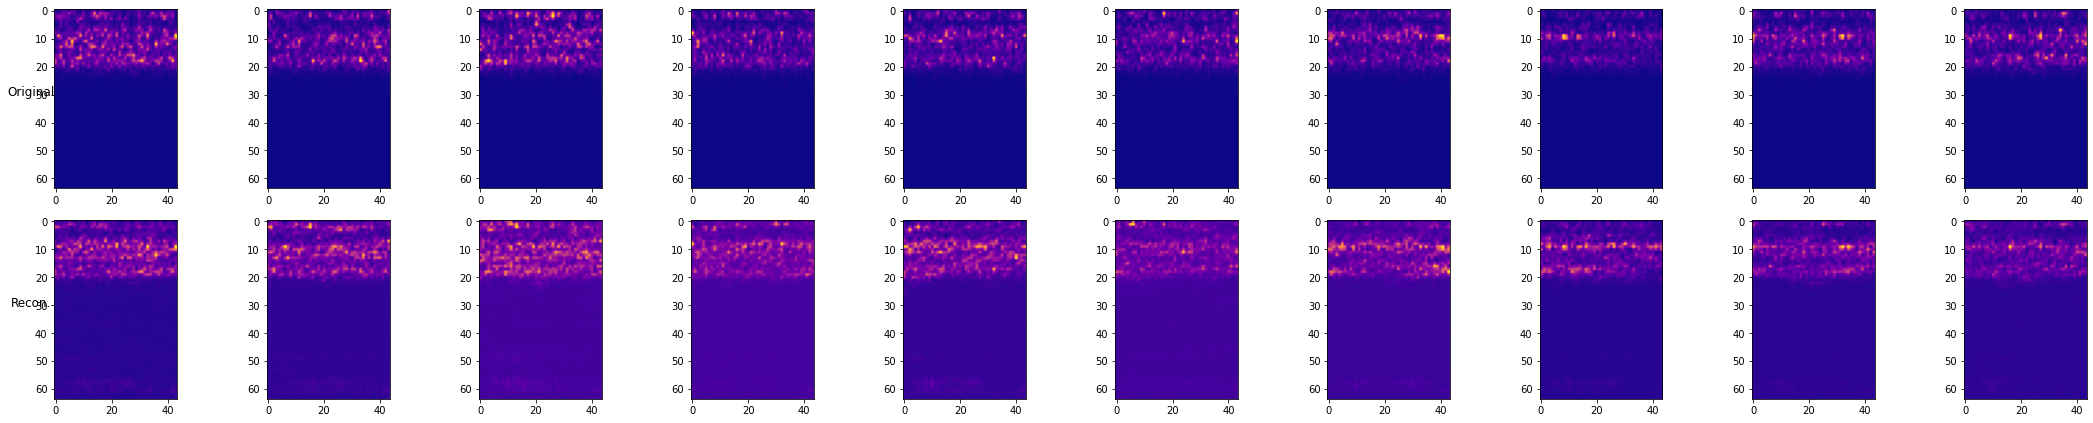

In [179]:
with torch.no_grad():
    plot_recons(model, device, 0, 10)

In [180]:
with torch.no_grad():
    save_audio(model, device, 509, 514)

Processing sample: 5/5
Saved audio files at path: sounds
